<a href="https://colab.research.google.com/github/cnydo/Image-colorization/blob/main/AI1605_Group5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!ls

sample_data


Upload kaggle.json to drive first then mount it the drive to use it

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls -l ~/.kaggle/kaggle.json

-rw------- 1 root root 62 Nov  7 18:15 /root/.kaggle/kaggle.json


Download from kaggle dataset

In [ ]:
!kaggle datasets download laurentmih/aisegmentcom-matting-human-datasets

100% 28.8G/28.8G [18:10<00:00, 25.3MB/s]
100% 28.8G/28.8G [18:10<00:00, 28.3MB/s]


In [ ]:
!unzip '/content/aisegmentcom-matting-human-datasets.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/matting_human_half/matting/1803271743/matting_00000000/1803271743-00000298.png  
  inflating: /content/dataset/matting_human_half/matting/1803271743/matting_00000000/1803271743-00000304.png  
  inflating: /content/dataset/matting_human_half/matting/1803271743/matting_00000000/1803271743-00000315.png  
  inflating: /content/dataset/matting_human_half/matting/1803271743/matting_00000000/1803271743-00000323.png  
  inflating: /content/dataset/matting_human_half/matting/1803271743/matting_00000000/1803271743-00000324.png  
  inflating: /content/dataset/matting_human_half/matting/1803271743/matting_00000000/1803271743-00000327.png  
  inflating: /content/dataset/matting_human_half/matting/1803271743/matting_00000000/1803271743-00000330.png  
  inflating: /content/dataset/matting_human_half/matting/1803271743/matting_00000000/1803271743-00000339.png  
  inflating: /content/dataset/matting_human_half/matting/1803

In [ ]:
!pip install basic_image_eda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install scikit-image scipy sklearn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=33efb02b37b3ce0062830c342eba725849d7da36ae9beb6e39e1574989910ec0
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built sklearn


In [ ]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from time import time
from PIL import Image
from basic_image_eda import BasicImageEDA
import cv2
import skimage
from skimage.color import rgb2lab, lab2rgb


import glob
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
from itertools import islice

import tensorflow as tf

# Runtime 
We are going to use the Colab PRO's GPU to train the model so let's first check the current notebook GPU and high-RAM setting

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov  7 18:43:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    59W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
torch.cuda.current_device()

0

In [ ]:
torch.cuda.device(0)

In [ ]:
torch.cuda.device_count()

1

In [ ]:
torch.cuda.get_device_name(0)

'A100-SXM4-40GB'

In [ ]:
sess =  tf.compat.v1.Session(config= tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0



# EDA

Use glob() to retrieve the data's path

In [ ]:
human_ds_path = r"/content/dataset/clip_img"
human_img_paths = glob.glob(human_ds_path + "/**/*.jpg", recursive=True)

Split the dataset into train, validation and test sets with ratio of 8:1:1

In [ ]:
train_paths, val_test_paths = train_test_split(human_img_paths, test_size=0.2,random_state=42)
val_paths,test_paths = train_test_split(val_test_paths, test_size=0.5, random_state=42)
print("train images:", len(train_paths))
print("val images:", len(val_paths))
print("test images:", len(test_paths))

train images: 27540
val images: 3442
test images: 3443


Start EDA with BasicImageEDA package


found 34425 images.
Using 12 threads. (max:12)



100%|██████████| 34425/34425 [05:00<00:00, 114.66it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  34425

dtype                                    |  uint8
channels                                 |  [3]
extensions                               |  ['jpg']

min height                               |  800
max height                               |  800
mean height                              |  800.0
median height                            |  800

min width                                |  600
max width                                |  600
mean width                               |  600.0
median width                             |  600

mean height/width ratio                  |  1.3333333333333333
median height/width ratio                |  1.3333333333333333
recommended input size(by mean)          |  [800 600] (h x w, multiples of 8)
recommended input size(by mean)          |  [800 608] (h x w, multiples of 16)
recommended input size(by mean)    

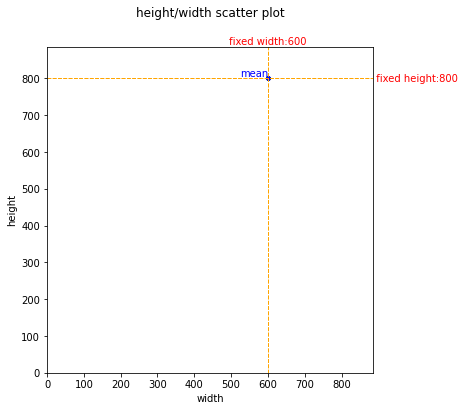

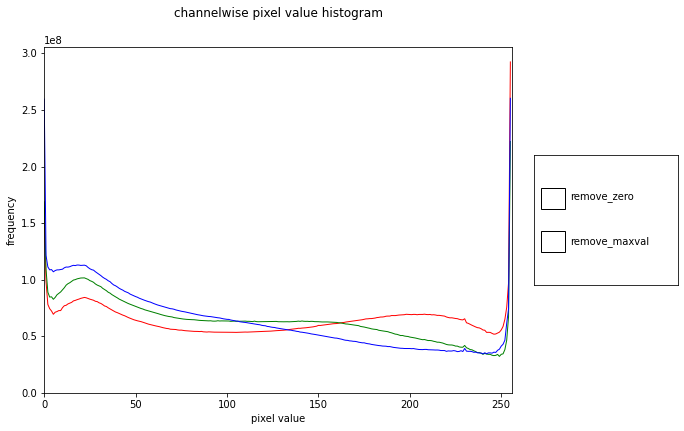

{'dtype': 'uint8',
 'channels': [3],
 'extensions': ['jpg'],
 'min_h': 800,
 'max_h': 800,
 'mean_h': 800.0,
 'median_h': 800,
 'min_w': 600,
 'max_w': 600,
 'mean_w': 600.0,
 'median_w': 600,
 'mean_hw_ratio': 1.3333333333333333,
 'median_hw_ratio': 1.3333333333333333,
 'rec_hw_size_8': array([800, 600]),
 'rec_hw_size_16': array([800, 608]),
 'rec_hw_size_32': array([800, 608]),
 'mean': array([0.493729  , 0.43179843, 0.3994736 ], dtype=float32),
 'std': array([0.30542526, 0.2891053 , 0.2929794 ], dtype=float32)}

In [ ]:
extensions = ['jpg']
threads = 0
dimension_plot = True
channel_hist = True
nonzero = False
hw_division_factor = 1.0
BasicImageEDA.explore(human_ds_path, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)

A mere look at the histogram and scatter plot shows us some important facts of the whole dataset:
- All of the images are in the same size (600x800)
- Overall the distribution of channelwise pixel value covers a large range of values means that the dataset is not too dark or light

# Data processing


## Custom Dataset
First we created a custom dataset that can do the followings: 
1. Resize the images to 256x256 
2. Convert RGB color space to LAB color space and 
3. Scale the LAB values to $[-1,1]$ to feed the model later

**Note**: [RGB to LAB conversion issue](https://github.com/tensorflow/io/issues/1451)

In [ ]:
SIZE = 256
class ColorizationDataset:
    def __init__(self, paths, split = 'train') -> None:
        # set self.transforms based on split type 
        if split == 'train':
            self.transforms = transforms.Compose([
                # Resize
                transforms.Resize((SIZE,SIZE), transforms.InterpolationMode.BICUBIC), 
                # Flip
                transforms.RandomHorizontalFlip(),  
            ])
        elif (split == 'val') or (split == 'test'):
            self.transforms = transforms.Resize((SIZE, SIZE), transforms.InterpolationMode.BICUBIC)
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)  
        img = np.array(img)
        # convert to lab color space and convert to float32
        img_lab = rgb2lab(img).astype("float32") 
        img_lab = transforms.ToTensor()(img_lab)
        # luminance channel
        L = img_lab[[0], ...] 
        # color channels 
        ab = img_lab[[1, 2], ...] 
        # Scale from [0, 100] to [-1, 1]
        L = L / 50 - 1
        # Scale from [-110, 110] to [-1, 1] 
        ab = ab / 110.
        return {"L": L, "ab": ab}
    
    def __len__(self):
        "Returning the length of the dataset."
        return len(self.paths) 
    
def make_loader(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    """Handy function to make DataLoader from the custom ColorizationDataset"""
    ds = ColorizationDataset(**kwargs)
    loader = DataLoader(ds, batch_size=16, num_workers=4, pin_memory=pin_memory)
    return loader

## Create a DataLoader from custom Dataset
As data storage is often slow, in particular due to access latency, we want to parallelize data loading. 

The Dataloader is defined as a process that combines the dataset and supplies an iteration over the given dataset. 

In [ ]:
train_dloader = make_loader(paths = train_paths,split = 'train')
val_dloader = make_loader(paths = val_paths, split = 'val')
test_dloader = make_loader(paths = test_paths, split = 'test')

In [ ]:
data = next(iter(train_dloader))

In [ ]:
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dloader), len(val_dloader))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
1722 216


We can see the L channel and ab has been splitted and ready to use for the model

# Model

## What is GANs?

[Generative adversarial networks](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf) consist of an overall structure composed of two neural networks, one called the generator and the other called the discriminator.

The role of the generator is to estimate the probability distribution of the real samples in order to provide generated samples resembling real data. The discriminator, in turn, is trained to estimate the probability that a given sample came from the real data rather than being provided by the generator.
<center>
  <figure>
    <img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto" height=350/>
      <p style="text-align: center">
      <b>Figure 1. Generative Adversarial Network architecture</b>
      <figcaption>
    In short, GANs consist of two neural networks, one trained to generate data and the other trained to distinguish fake data from real data (hence the “adversarial” nature of the model).
      </figcaption>
      </p>
</figure>
</center>


These structures are called generative adversarial networks because the generator and discriminator are trained to compete with each other: the generator tries to get better at fooling the discriminator, while the discriminator tries to get better at identifying generated samples.

## Building U-Net as generator of GANs
<center>
  <figure>
    <img src="https://raw.githubusercontent.com/ImagingLab/Colorizing-with-GANs/master/img/unet.png" style="display:block; margin:auto" height=200 width=1200/>
      <p style="text-align: center">
      <figcaption>
      <b>Figure 2. U-Net architecture</b>
      </figcaption>
      </p>
  </figure>
</center>

In [ ]:
class UnetBlock(nn.Module):
    """U-Net block"""
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False) -> None:
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4, stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    """U-Net architecture"""
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64) -> None:
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)
            

##Building Dicriminator
The architecture of our discriminator is rather straight forward. This code implements a model by stacking blocks of Conv-BatchNorm-LeackyReLU to decide whether the input image is fake or real. Notice that the first and last blocks do not use normalization and the last block has no activation function (it is embedded in the loss function we will use).


In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        # the 'if' statement is taking care of not using stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) for i in range(n_down)]
        # Make sure to not use normalization or activation for the last layer of the model
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] 
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): 
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

## Building GAN loss

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

## Initiate the weight


In [ ]:
def init_weights(net, init='norm', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')   
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

## Main model

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward() # calculate gradient
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward() # calculate gradient
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

def add_history(history, loss_meter_dict):
    res = history
    for loss_name, loss_meter in loss_meter_dict.items():
        res[loss_name].append(loss_meter.avg)
    return res

def plot_history(history):
    fig, ax = plt.subplots(3, 2, figsize=(10, 10))
    ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()
    ax1.plot(history['loss_D_fake'])
    ax1.set_title('loss_D_fake')
    ax2.plot(history['loss_D_real'])
    ax2.set_title('loss_D_real')
    ax3.plot(history['loss_D'])
    ax3.set_title('loss_D')
    ax4.plot(history['loss_G_GAN'])
    ax4.set_title('loss_G_GAN')
    ax5.plot(history['loss_G_L1'])
    ax5.set_title('loss_G_L1')
    ax6.plot(history['loss_G'])
    ax6.set_title('loss_G')
    plt.show()

In [ ]:
import time
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dloader)) # getting a batch for visualizing the model output after fixed intrvals
    history = {'loss_D_fake': [],
            'loss_D_real': [],
            'loss_D': [],
            'loss_G_GAN': [],
            'loss_G_L1': [],
            'loss_G': []}
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            for loss_name, loss_meter in loss_meter_dict.items():
                    history[loss_name].append(loss_meter.avg)
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses            
                visualize(model, data, save=True) # function displaying the model's outputs
    return history

model initialized with norm initialization
model initialized with norm initialization


 11%|█▏        | 197/1722 [00:30<04:07,  6.16it/s]


Epoch 1/1
Iteration 200/1722
loss_D_fake: 0.50188
loss_D_real: 0.53735
loss_D: 0.51962
loss_G_GAN: 1.42835
loss_G_L1: 9.05078
loss_G: 10.47914


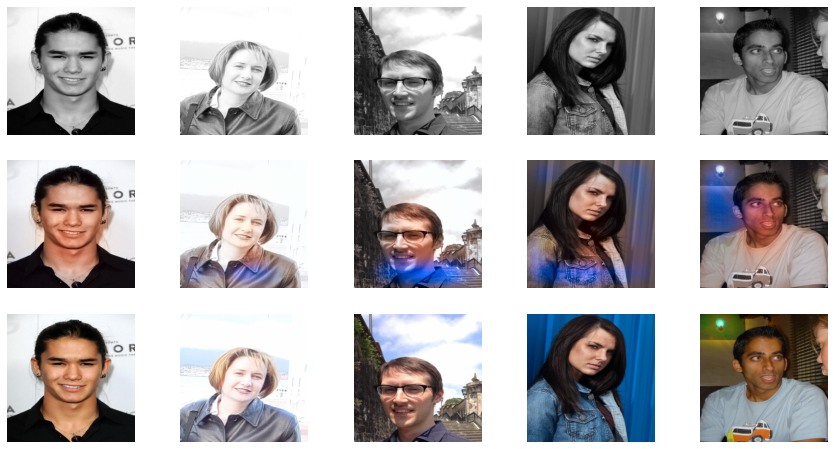

 23%|██▎       | 399/1722 [01:00<03:12,  6.86it/s]/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))



Epoch 1/1
Iteration 400/1722
loss_D_fake: 0.49665
loss_D_real: 0.52417
loss_D: 0.51041
loss_G_GAN: 1.45105
loss_G_L1: 9.08842
loss_G: 10.53948


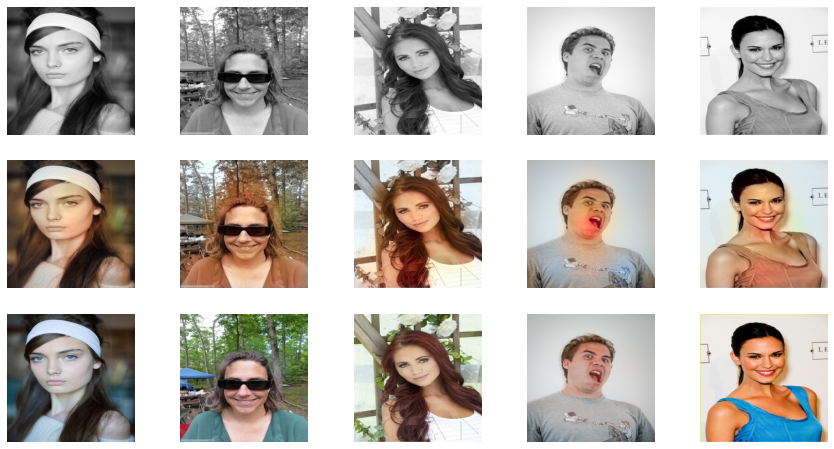

 35%|███▍      | 598/1722 [01:30<03:13,  5.81it/s]/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 10 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))



Epoch 1/1
Iteration 600/1722
loss_D_fake: 0.49806
loss_D_real: 0.52617
loss_D: 0.51212
loss_G_GAN: 1.41870
loss_G_L1: 9.23938
loss_G: 10.65808


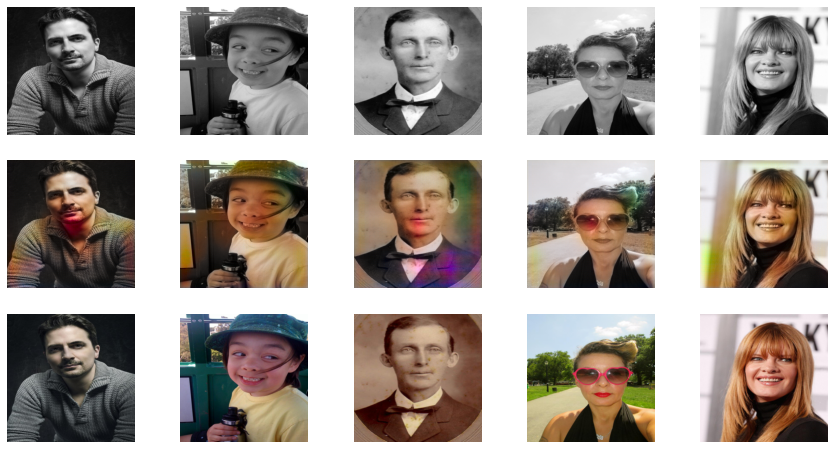

 46%|████▋     | 798/1722 [02:01<02:21,  6.55it/s]


Epoch 1/1
Iteration 800/1722
loss_D_fake: 0.50258
loss_D_real: 0.53657
loss_D: 0.51958
loss_G_GAN: 1.38203
loss_G_L1: 9.25429
loss_G: 10.63631


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 17 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


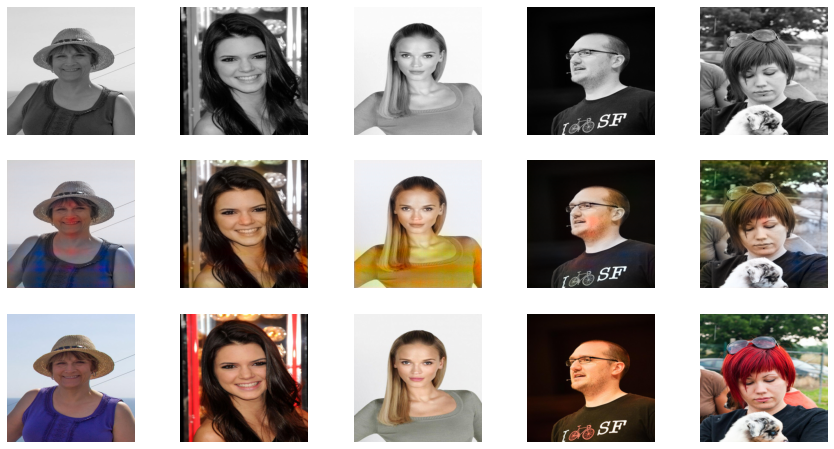

 58%|█████▊    | 998/1722 [02:31<01:53,  6.37it/s]/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 39 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))



Epoch 1/1
Iteration 1000/1722
loss_D_fake: 0.50828
loss_D_real: 0.54274
loss_D: 0.52551
loss_G_GAN: 1.35380
loss_G_L1: 9.30122
loss_G: 10.65502


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 48 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


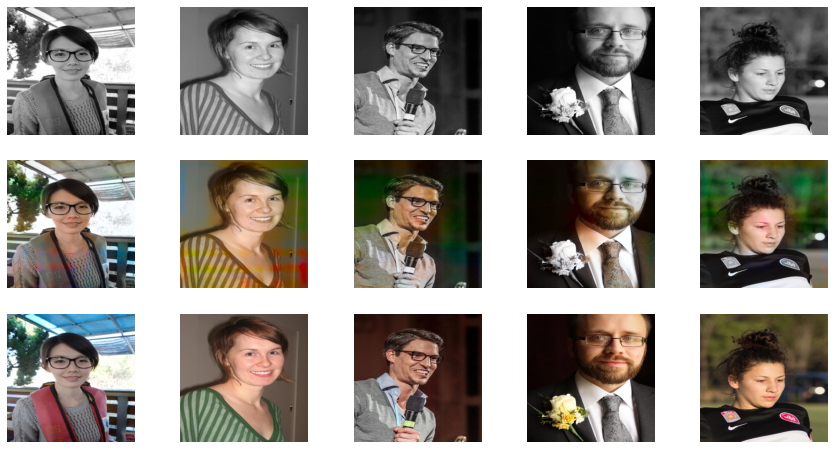

 70%|██████▉   | 1198/1722 [03:01<01:22,  6.37it/s]


Epoch 1/1
Iteration 1200/1722
loss_D_fake: 0.51064
loss_D_real: 0.54877
loss_D: 0.52970
loss_G_GAN: 1.33902
loss_G_L1: 9.32040
loss_G: 10.65942


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 78 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


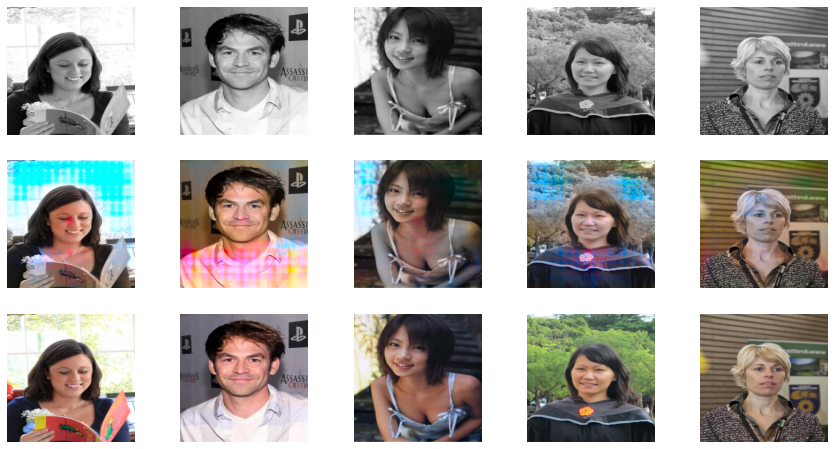

 81%|████████  | 1398/1722 [03:32<00:50,  6.39it/s]/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))



Epoch 1/1
Iteration 1400/1722
loss_D_fake: 0.51189
loss_D_real: 0.55233
loss_D: 0.53211
loss_G_GAN: 1.32389
loss_G_L1: 9.35380
loss_G: 10.67768


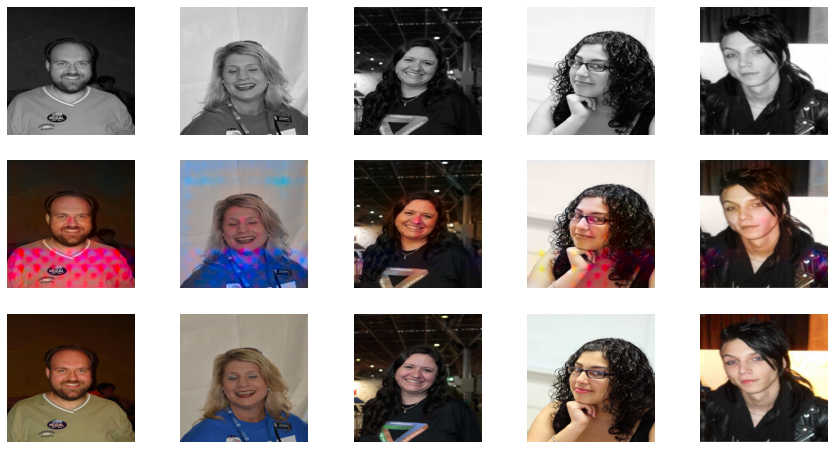

 93%|█████████▎| 1598/1722 [04:02<00:19,  6.52it/s]/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))



Epoch 1/1
Iteration 1600/1722
loss_D_fake: 0.51307
loss_D_real: 0.55458
loss_D: 0.53383
loss_G_GAN: 1.31436
loss_G_L1: 9.36855
loss_G: 10.68291


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


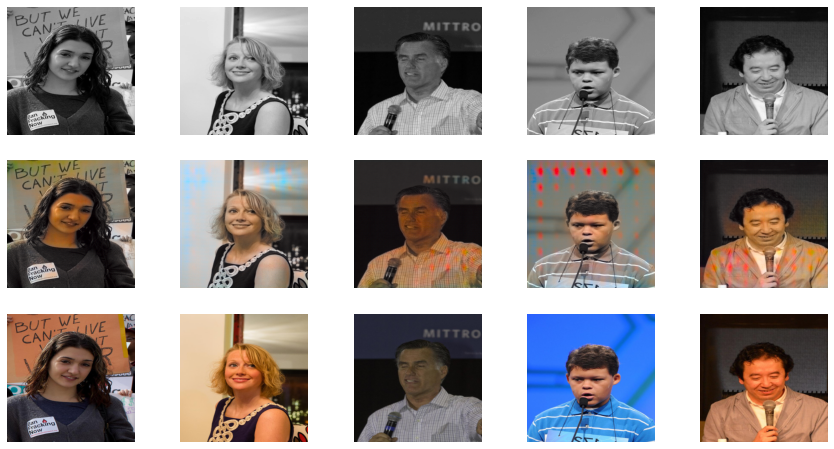

100%|██████████| 1722/1722 [04:21<00:00,  6.58it/s]


In [ ]:
import time
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dloader)) # getting a batch for visualizing the model output after fixed intrvals
    history = {'loss_D_fake': [],
            'loss_D_real': [],
            'loss_D': [],
            'loss_G_GAN': [],
            'loss_G_L1': [],
            'loss_G': []}
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                for loss_name, loss_meter in loss_meter_dict.items():
                    history[loss_name].append(loss_meter.avg)
                visualize(model, data, save=True) # function displaying the model's outputs
    return history
    

model = MainModel()

with tf.device('/device:GPU:0'):
    # Start with 10 epochs
    history = train_model(model, train_dloader, 1)




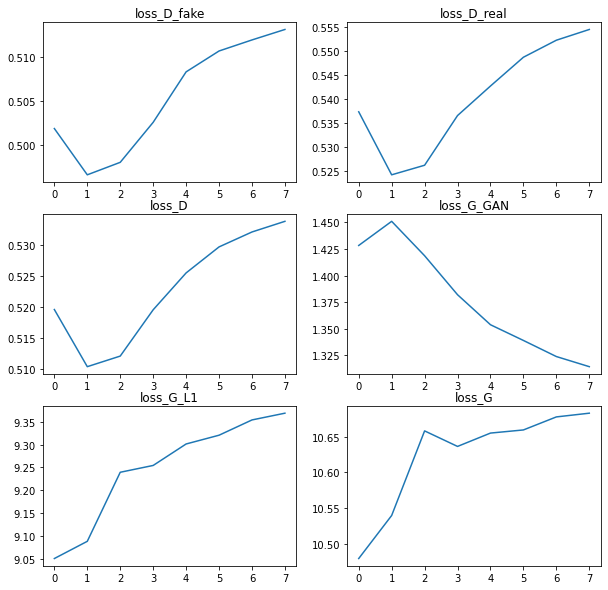

In [ ]:
plot_history(history)

In [ ]:
torch.save(model.state_dict(), r'/content/drive/MyDrive/Colab Notebooks/Saved_model/model1')

In [ ]:
model_10 = MainModel()

with tf.device('/device:GPU:0'):
    history = train_model(model_10, train_dloader, 10)

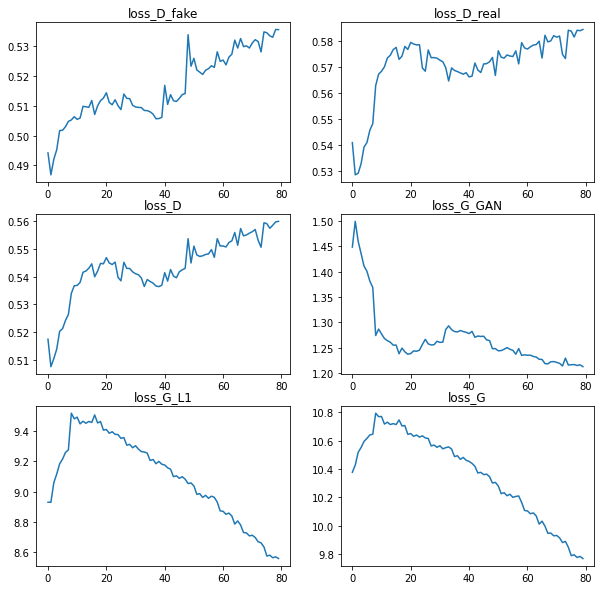

In [ ]:
plot_history(history)

In [ ]:
torch.save(model_10.state_dict(), r'/content/drive/MyDrive/Colab Notebooks/Saved_model/model_10')

In [ ]:
model_20 = MainModel()

with tf.device('/device:GPU:0'):
    history = train_model(model_20, train_dloader, 20)

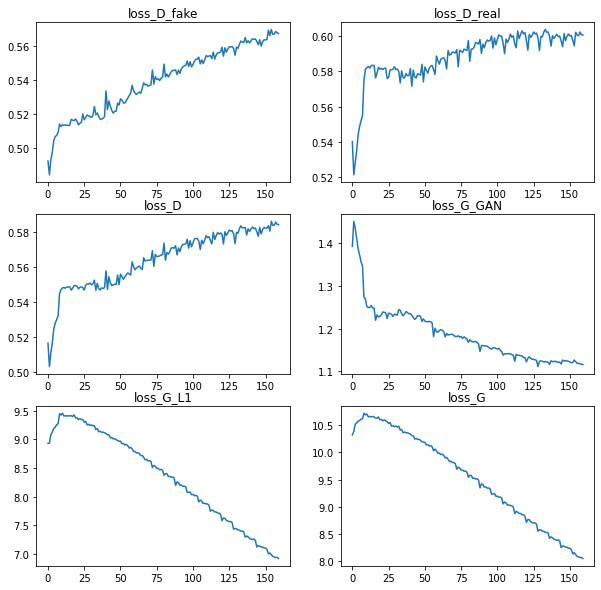

In [ ]:
plot_history(history)

In [ ]:
torch.save(model_20.state_dict(), r'/content/drive/MyDrive/Colab Notebooks/Saved_model/model_20')

In [ ]:
model_30 = MainModel()

with tf.device('/device:GPU:0'):
    history = train_model(model_30, train_dloader, 30)

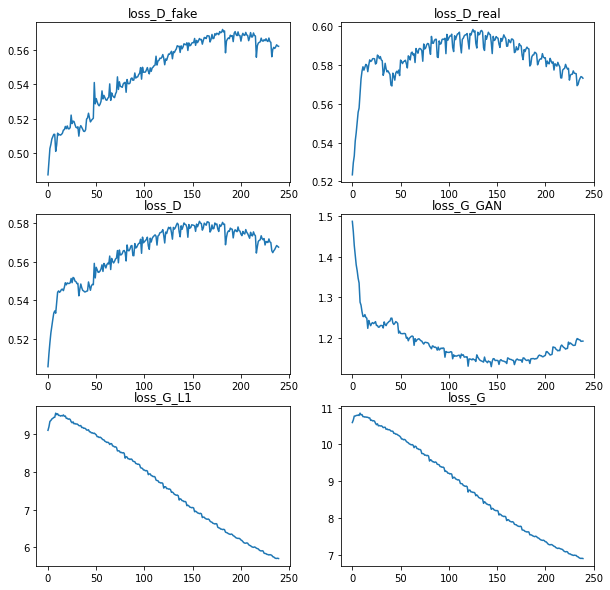

In [ ]:
plot_history(history)

In [ ]:
torch.save(model_30.state_dict(), r'/content/drive/MyDrive/Colab Notebooks/Saved_model/model_30')

# Metrics

## [PSNR: Peak Signal-to-Noise Ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#:~:text=Peak%20signal%2Dto%2Dnoise%20ratio%20(PSNR)%20is%20an,the%20fidelity%20of%20its%20representation.)
Peak signal-to-noise ratio, often abbreviated PSNR, is an engineering term for the ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation.

Formula: $$P S N R=20 \log _{10}\left(\frac{M A X_{f}}{\sqrt{M S E}}\right)$$

where 
- $M S E=\frac{1}{m n} \sum_{0}^{m-1} \sum_{0}^{n-1}\|f(i, j)-g(i, j)\|^{2}$
- $M A X_{f}$ is the maximum value of pixel. In 8 bits this is 255

PSNR uses decibel (dB)  as the unit of measurement.
Typical values for the PSNR in lossy image and video compression are between 30 and 50 dB, provided the bit depth is 8 bits, where higher is better. The processing quality of 12-bit images is considered high when the PSNR value is 60 dB or higher. For 16-bit data typical values for the PSNR are between 60 and 80 dB. Acceptable values for wireless transmission quality loss are considered to be about 20 dB to 25 dB




## [SSIM: Structural similarity](https://en.wikipedia.org/wiki/Structural_similarity)
The difference with respect to other techniques mentioned previously such as MSE or PSNR is that these approaches estimate absolute errors; on the other hand, SSIM is a perception-based model that considers image degradation as perceived change in structural information, while also incorporating important perceptual phenomena, including both luminance masking and contrast masking terms. Structural information is the idea that the pixels have strong inter-dependencies especially when they are spatially close. These dependencies carry important information about the structure of the objects in the visual scene.

Formula: 
$$\hbox{SSIM}(x,y)={\frac  {(2\mu _{x}\mu _{y}+c_{1})(2\sigma _{xy}+c_{2})}{(\mu _{x}^{2}+\mu _{y}^{2}+c_{1})(\sigma _{x}^{2}+\sigma _{y}^{2}+c_{2})}}$$

with
- $\mu _{x}$ is the sample mean of $x$
- $\mu _{y}$ is the sample mean of $y$
- $\sigma _{x}^{2}$ variance of $x$
- $\sigma _{y}^{2}$ variance of $y$
- $\sigma _{xy}$ covariance of $x$ and $y$
- $c_{i}=(k_{i}L)^{2}$ where $k_{1} = 0.01$ and $k_{2} = 0.03$ by default.
- $L$ is the [dynamic range](https://en.wikipedia.org/wiki/Dynamic_range)

In order to evaluate the image quality, this formula is usually applied only on luma, although it may also be applied on color (e.g., RGB) values or chromatic (e.g. YCbCr) values. The resultant SSIM index is a decimal value between -1 and 1, where 1 indicates perfect similarity, 0 indicates no similarity, and -1 indicates perfect anti-correlation. 

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [ ]:
def test_model(model, test_set=test_dloader, display_every = 200, save = False):
    data = next(iter(test_set))
    i = 0
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    print('PSNR: {psnr}'.format(psnr=psnr(fake_imgs, real_imgs)))
    print('SSIM: {ssim}'.format(ssim=ssim(fake_imgs, real_imgs, multichannel = True)))
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

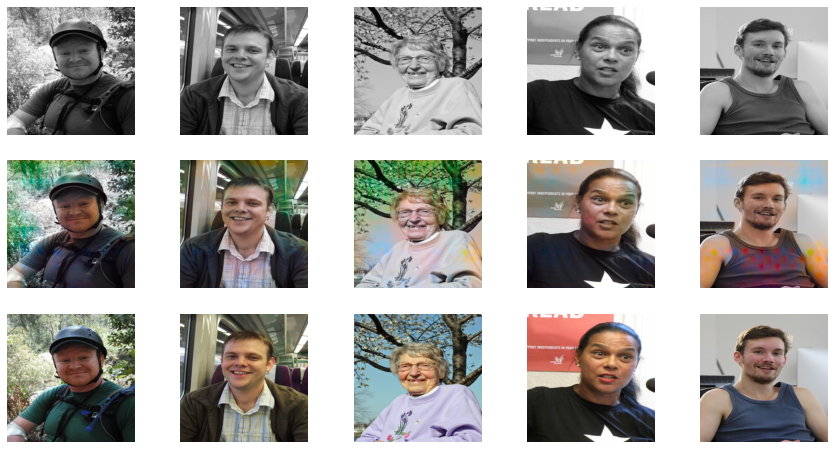

PSNR: 19.588105636528816
SSIM: 0.9007247741694361


In [ ]:
test_model(model)

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


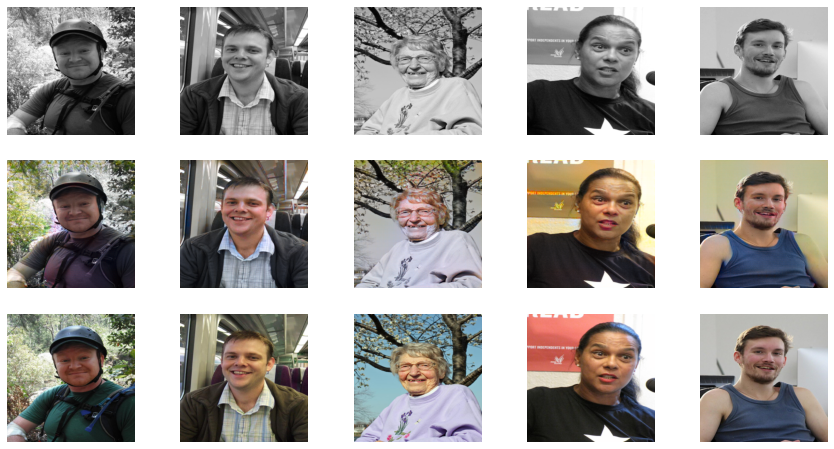

PSNR: 20.79970276741944
SSIM: 0.9234445890506611


In [ ]:
test_model(model_10)

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


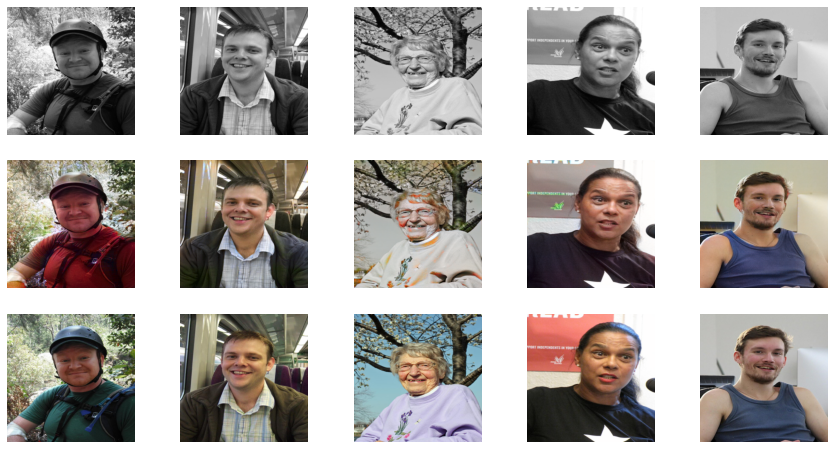

PSNR: 19.6436475740107
SSIM: 0.8962384610624946


In [ ]:
test_model(model_20)

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


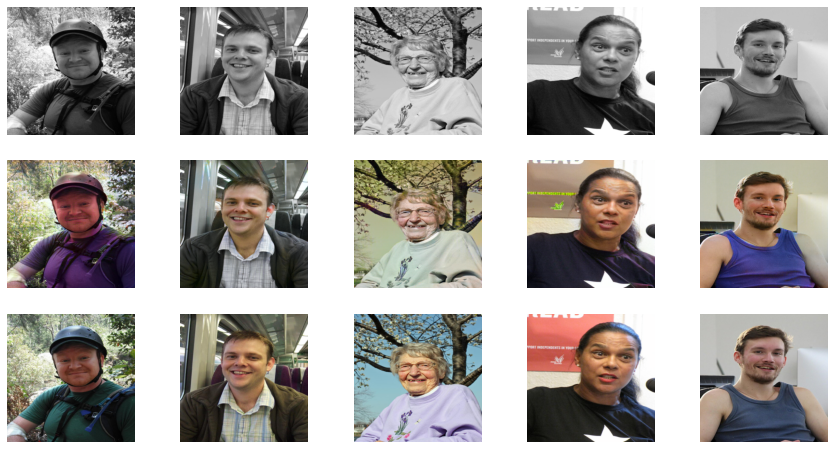

PSNR: 20.621386760950685
SSIM: 0.9183961898504265


In [ ]:
test_model(model_30)

In [ ]:
new_path = r'/content/dataset/new'
new_paths = glob.glob(new_path + "/*.jpg", recursive=True)

In [ ]:
new_loader = make_loader(paths = new_paths, split = 'test')

IndexError: ignored

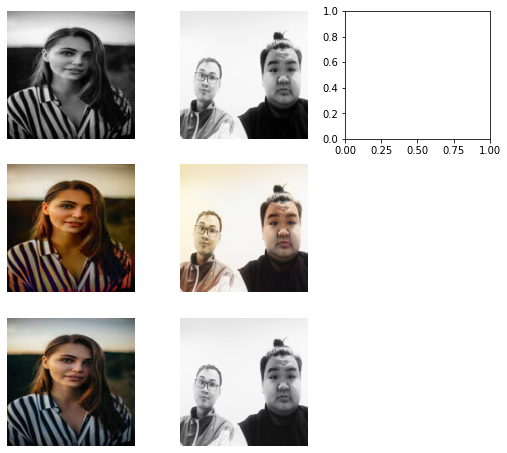

In [ ]:
test_model(model_30, test_set = new_loader)